In [1]:
# =============================================================
# 🌍 Environment Bootstrap — ensure src/ is importable
# =============================================================
import sys
from pathlib import Path

CWD = Path.cwd().resolve()

if (CWD / "src").exists():
    PROJECT_ROOT = CWD
elif (CWD.name == "notebooks") and (CWD.parent / "src").exists():
    PROJECT_ROOT = CWD.parent
else:
    PR = CWD
    for _ in range(3):
        if (PR / "src").exists():
            PROJECT_ROOT = PR
            break
        PR = PR.parent
    else:
        raise RuntimeError("❌ Could not locate project root containing src/")

if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

print(f"✅ Project root: {PROJECT_ROOT}")

✅ Project root: /Users/olia_/projects/Kaggle/csiro-biomass


In [2]:
# =============================================================
# 📦 Import project modules
# =============================================================
from src.config import (
    DATA_DIR, TRAIN_IMG_DIR, TEST_IMG_DIR,
    TRAIN_CSV, TEST_CSV,
    ensure_output_dirs, verify_layout
)
from src.data_loading import load_train_data, load_test_data, sample_image_stats

# Basic setup checks
ensure_output_dirs()
verify_layout(strict=True)

print("🧩 CONFIGURATION CHECK")
print(f"DATA_DIR: {DATA_DIR}")
print(f"TRAIN_IMG_DIR: {TRAIN_IMG_DIR.exists()} → {TRAIN_IMG_DIR}")
print(f"TEST_IMG_DIR:  {TEST_IMG_DIR.exists()} → {TEST_IMG_DIR}")
print(f"TRAIN_CSV: {TRAIN_CSV.exists()} → {TRAIN_CSV}")
print(f"TEST_CSV:  {TEST_CSV.exists()}  → {TEST_CSV}")

🧩 CONFIGURATION CHECK
DATA_DIR: /Users/olia_/projects/Kaggle/csiro-biomass/input_local
TRAIN_IMG_DIR: True → /Users/olia_/projects/Kaggle/csiro-biomass/input_local/train
TEST_IMG_DIR:  True → /Users/olia_/projects/Kaggle/csiro-biomass/input_local/test
TRAIN_CSV: True → /Users/olia_/projects/Kaggle/csiro-biomass/input_local/train.csv
TEST_CSV:  True  → /Users/olia_/projects/Kaggle/csiro-biomass/input_local/test.csv


In [3]:
# =============================================================
# 🧱 Load training and test dataframes
# =============================================================
train_df, img_col, tgt_col = load_train_data()
test_df, test_img_col      = load_test_data()

print(f"📊 train_df shape: {train_df.shape}")
print(f"📊 test_df shape:  {test_df.shape}")
print(f"🖼️ Image column: {img_col}, Target column: {tgt_col}")

📊 train_df shape: (1785, 9)
📊 test_df shape:  (5, 3)
🖼️ Image column: image_path, Target column: target


In [4]:
# =============================================================
# 🔎 Column overview
# =============================================================
print("Train columns:", train_df.columns.tolist())
print("Test  columns:", test_df.columns.tolist())

# Quick head previews
display(train_df.head(3))
display(test_df.head(3))

Train columns: ['sample_id', 'image_path', 'Sampling_Date', 'State', 'Species', 'Pre_GSHH_NDVI', 'Height_Ave_cm', 'target_name', 'target']
Test  columns: ['sample_id', 'image_path', 'target_name']


,sample_id,image_path,Sampling_Date,State,Species,Pre_GSHH_NDVI,Height_Ave_cm,target_name,target
0,ID1011485656__Dry_Clover_g,/Users/olia_/projects/Kaggle/csiro-biomass/inp...,2015/9/4,Tas,Ryegrass_Clover,0.62,4.6667,Dry_Clover_g,0.0000
1,ID1011485656__Dry_Dead_g,/Users/olia_/projects/Kaggle/csiro-biomass/inp...,2015/9/4,Tas,Ryegrass_Clover,0.62,4.6667,Dry_Dead_g,31.9984
2,ID1011485656__Dry_Green_g,/Users/olia_/projects/Kaggle/csiro-biomass/inp...,2015/9/4,Tas,Ryegrass_Clover,0.62,4.6667,Dry_Green_g,16.2751


,sample_id,image_path,target_name
0,ID1001187975__Dry_Clover_g,/Users/olia_/projects/Kaggle/csiro-biomass/inp...,Dry_Clover_g
1,ID1001187975__Dry_Dead_g,/Users/olia_/projects/Kaggle/csiro-biomass/inp...,Dry_Dead_g
2,ID1001187975__Dry_Green_g,/Users/olia_/projects/Kaggle/csiro-biomass/inp...,Dry_Green_g


In [5]:
# =============================================================
# 🧮 Missing Value Analysis
# =============================================================
print("Missing values (train):")
display(train_df.isna().sum().sort_values(ascending=False).head(20))

print("Missing values (test):")
display(test_df.isna().sum().sort_values(ascending=False).head(20))

Missing values (train):


sample_id        0
image_path       0
Sampling_Date    0
State            0
Species          0
Pre_GSHH_NDVI    0
Height_Ave_cm    0
target_name      0
target           0
dtype: int64

Missing values (test):


sample_id      0
image_path     0
target_name    0
dtype: int64

In [6]:
# =============================================================
# 📂 Verify required files and image directories
# =============================================================
from pathlib import Path

required_files = ["train.csv", "test.csv", "sample_submission.csv"]
for f in required_files:
    path = Path(DATA_DIR) / f
    print(f"{f:25} →", "✅ Exists" if path.exists() else "❌ Missing")

train_dir = Path(DATA_DIR) / "train"
test_dir  = Path(DATA_DIR) / "test"

print("\ntrain/ dir exists:", train_dir.exists())
print("test/ dir exists:", test_dir.exists())

train_imgs = list(train_dir.glob("*.jpg"))
test_imgs  = list(test_dir.glob("*.jpg"))

print(f"\nTrain images: {len(train_imgs):,}")
print(f"Test images:  {len(test_imgs):,}")

train.csv                 → ✅ Exists
test.csv                  → ✅ Exists
sample_submission.csv     → ✅ Exists

train/ dir exists: True
test/ dir exists: True

Train images: 357
Test images:  1


In [7]:
# =============================================================
# 🖼️ Image statistics sampling
# =============================================================
from pprint import pprint

train_stats = sample_image_stats(train_df, image_path_col="image_path", max_samples=200)
test_stats  = sample_image_stats(test_df,  image_path_col="image_path", max_samples=50)

print("Train image stats:")
pprint(train_stats)
print("\nTest image stats:")
pprint(test_stats)

Train image stats:
{'bad': 0,
 'height_max': 1000,
 'height_mean': 1000.0,
 'height_min': 1000,
 'missing': 0,
 'n_examined': 200,
 'sizes_count': 200,
 'width_max': 2000,
 'width_mean': 2000.0,
 'width_min': 2000}

Test image stats:
{'bad': 0,
 'height_max': 1000,
 'height_mean': 1000.0,
 'height_min': 1000,
 'missing': 0,
 'n_examined': 5,
 'sizes_count': 5,
 'width_max': 2000,
 'width_mean': 2000.0,
 'width_min': 2000}


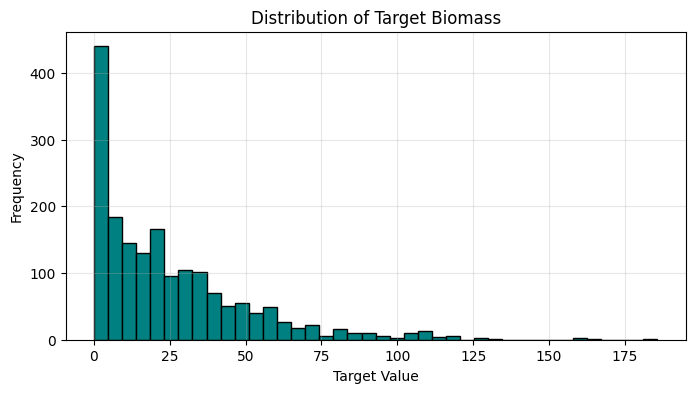

✅ EDA notebook initialization complete.


In [8]:
# =============================================================
# 📊 Basic EDA visualization
# =============================================================
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
train_df[tgt_col].hist(bins=40, color="teal", edgecolor="black")
plt.title("Distribution of Target Biomass")
plt.xlabel("Target Value")
plt.ylabel("Frequency")
plt.grid(alpha=0.3)
plt.show()

print("✅ EDA notebook initialization complete.")
